In [3]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 28 10:24:21 2023

@author: 20122
"""

import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request as urllib2
import json
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
import matplotlib
matplotlib.rcParams['font.family'] = 'Times New Roman'
df1 = pd.read_excel('SC2212.INE.xlsx')
df2 = pd.read_excel('SC2303.INE.xlsx')

df1.rename(columns={'日期':'date','收盘价(元)':'close'},inplace=True)
df2.rename(columns={'日期':'date','收盘价(元)':'close'},inplace=True)

df1.dropna(inplace=True)
df2.dropna(inplace=True)
df1['date'] = df1['date'].astype(str)
df2['date'] = df2['date'].astype(str)
df1['date'] = df1['date'].apply(lambda x:int(x[:4]+x[5:7]+x[8:10]))
df2['date'] = df2['date'].apply(lambda x:int(x[:4]+x[5:7]+x[8:10]))




In [4]:
def get_corr_between(start_date,end_date,df1=df1,df2=df2):
    df1_part = df1[(df1['date'] >= start_date) & (df1['date'] <= end_date)]
    df2_part = df2[(df2['date'] >= start_date) & (df2['date'] <= end_date)]
    df1_name = df1.iloc[:,0].values[0]
    df2_name = df2.iloc[:,0].values[0]
    df1_part.rename(columns={'close':df1_name},inplace= True)
    df2_part.rename(columns={'close':df2_name}, inplace=True)
    return pd.merge(df1_part[['date',df1_name]],df2_part[['date',df2_name]],on='date')
def ADF_test(data):
    result = adfuller(data)
    print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')
    if result[1]>0.05:
        return False
    else:
        return True
def check_co_integrated(y,x):
    x = sm.add_constant(x)
    # 创建线性回归模型并拟合数据
    model = sm.OLS(y, x)
    results = model.fit()
    # 获取残差
    residuals = results.resid
    result = adfuller(residuals)
    print(f'Result: y 与 x {"不" if result[1] > 0.05 else ""}存在协整关系')
    if result[1]>0.05:
        return False
    else:
        return True

In [5]:
matrix = get_corr_between(20210302,20220302)
print('0阶')
ADF_test(matrix.iloc[:,1])
ADF_test(matrix.iloc[:,2])
ADF_test(matrix.iloc[:,1].diff()[1:])
ADF_test(matrix.iloc[:,2].diff()[1:])

0阶
Result: The series is not stationary
Result: The series is not stationary
Result: The series is stationary
Result: The series is stationary


True

In [6]:
ADF_test(matrix.iloc[:,1].diff()[1:])
ADF_test(matrix.iloc[:,2].diff()[1:])

Result: The series is stationary
Result: The series is stationary


True

In [7]:
check_co_integrated(matrix.iloc[:,1],matrix.iloc[:,2])

Result: y 与 x 存在协整关系


True

In [8]:
def check_group(input_data):
    y = np.log(input_data.iloc[:,1].values)
    x = np.log(input_data.iloc[:,2].values)
    print('对lny平稳性检验')
    ADF_test(y)
    print('对lnx平稳性检验')
    ADF_test(x)
    print('对lny一阶差分平稳性检验')
    ADF_test(pd.DataFrame(y).diff()[1:])
    print('对lnx一阶差分平稳性检验')
    ADF_test(pd.DataFrame(x).diff()[1:])
    print('检验协整关系')
    if check_co_integrated(y,x):
        return True
    else:
        return False
    

In [9]:
#检验对数价格协整关系
check_group(matrix)

对lny平稳性检验
Result: The series is not stationary
对lnx平稳性检验
Result: The series is not stationary
对lny一阶差分平稳性检验
Result: The series is stationary
对lnx一阶差分平稳性检验
Result: The series is stationary
检验协整关系
Result: y 与 x 存在协整关系


True

In [26]:
class Co_arbitrage:
    def __init__(self,train_data,test_data,filename1='交易区间.png',filename2='模拟交易.png',filename3='累计收益率.png',free_risk=0.0181):
        self.train_data =train_data
        self.test_data =test_data
        self.free_risk = free_risk
        self.param = [0.75,1.25,0.25]
        self.matric = np.zeros((3,3))
        self.beta = 0 
        self.alpha = 0
        self.mean = 0
        self.sigma = 0
        self.filename1 = filename1
        self.filename2 =filename2
        self.filename3 =filename3
    def correlation_test(self):
        correlation = self.train_data.iloc[:,1].corr(self.train_data.iloc[:,2])
        print("训练集中，两者的相关系数：",correlation)
        if correlation >0.8:
            return True
        else:
            return False
    def cointegration_test(self):
        def ADF_test(data):
            result = adfuller(data)
            print('P-value:{:.2f}'.format(result[1]))
            print(f'Result: the series is {"not " if result[1] > 0.05 else ""}stationary'.format(result[1]))
            if result[1]>0.05:
                return False
            else:
                return True
        def check_co_integrated(y,x):
            x = sm.add_constant(x)
            # 创建线性回归模型并拟合数据
            model = sm.OLS(y, x)
            results = model.fit()
            # 获取残差
            residuals = results.resid
            result = adfuller(residuals)
            print('P-value:{:.2f}'.format(result[1]))
            print(f'Result: y 与 x {"不" if result[1] > 0.05 else ""}存在协整关系')
            if result[1]>0.05:
                return False
            else:
                return True
        y = np.log(self.train_data.iloc[:,1].values)
        x = np.log(self.train_data.iloc[:,2].values)
        print('对lny平稳性检验')
        ADF_test(y)
        print('对lnx平稳性检验')
        ADF_test(x)
        print('对lny一阶差分平稳性检验')
        ADF_test(pd.DataFrame(y).diff()[1:])
        print('对lnx一阶差分平稳性检验')
        ADF_test(pd.DataFrame(x).diff()[1:])
        print('检验协整关系')
        if check_co_integrated(y,x):
            return True
        else:
            return False
    def train(self,type='yield'):
        '''
        :param type: yield , sharp , withdraw
        :return: null
        '''
        self.correlation_test()
        self.cointegration_test()
        starts = np.arange(0.5,1.3,0.05)
        stops = np.arange(1.25,3.05,0.05)
        takes = np.arange(0,0.55,0.05)
        matric_matrix = np.zeros((len(starts),len(stops),len(takes)))
        # print(matric_matrix.shape)
        returns_1s= pd.DataFrame(np.log(self.train_data.iloc[:,1]/ self.train_data.iloc[:,1].shift(1)))
        returns_2s= pd.DataFrame(np.log(self.train_data.iloc[:,2]/ self.train_data.iloc[:,2].shift(1)))
        #初始化
        Price_y = self.train_data.iloc[:,1]
        Price_x = self.train_data.iloc[:,2] 
        Log_Py = np.log(Price_y)
        Log_Px = np.log(Price_x)
        #LogPy对LogPx作回归
        x = sm.add_constant(Log_Px)
        # 创建线性回归模型并拟合数据
        model = sm.OLS(Log_Py, x)
        results = model.fit()
        # intercept = results.self.params[0]
        self.beta = results.params[1]
        self.alpha = results.params[0]
        self.mean = np.mean(results.resid)
        self.sigma = np.std(results.resid)
        # print(beta)
        ratio_y = self.beta/(self.beta+1)
        ratio_x = 1/(self.beta+1)
        # 获取残差
        spread = results.resid
        mspread = spread - np.mean(spread)
        sigma = np.std(mspread)
        z_score_list = mspread/sigma
        for start_index in range(len(starts)):
            for stop_index in  range(len(stops)):
                for take_index in range(len(takes)):
                    start = starts[start_index]
                    stop = stops[stop_index]
                    take = takes[take_index]
                    hold = False #开仓为Ture
                    hold_state = 0
                    signals = []
                    for i in range(len(Price_y)):
                        if hold ==False:
                            if z_score_list[i] >= start:
                                hold_state = -1
                                hold = True
                            if  z_score_list[i]<= -start:
                                hold_state = 1
                                hold = True
                        else:
                            if  z_score_list[i]>=stop and hold_state==-1:
                                hold_state =0
                                hold = False
                            if  z_score_list[i]<=-stop and hold_state==1:
                                hold_state =0
                                hold =False
                            if  z_score_list[i]<=take and hold_state==-1:
                                hold_state = 0
                                hold = False
                            if  z_score_list[i]>=-take and hold_state==1:
                                hold_state = 0
                                hold = False
                        signals.append(hold_state)
                    position_1 = pd.DataFrame(np.array(signals))
                    position_2 = pd.DataFrame(-1*np.array(signals))
                    strategies=ratio_y*(position_1.iloc[:,0].shift(1) * returns_1s.iloc[:,0]) +ratio_x*(position_2.iloc[:,0].shift(1) * returns_2s.iloc[:,0])
                    #计算 各种指标
                    return_strategy_mean = strategies.dropna().mean()*252
                    sharp = (return_strategy_mean-self.free_risk)/strategies.dropna().std()*252
                    cumret=strategies.dropna().cumsum()
                    cummax=cumret.cummax()
                    down_max = (cummax-cumret).max()
                    if type =='yield':
                        # print([start_index,stop_index,take_index])
                        # print(return_strategy_mean)
                        matric_matrix[start_index,stop_index,take_index] = return_strategy_mean
                    if type =='sharp':
                        matric_matrix[start_index,stop_index,take_index] = sharp
                    if type =='withdraw':
                        matric_matrix[start_index,stop_index,take_index] = down_max
        if type=='yield' or type=='sharp':
            max_index = np.argmax(matric_matrix)
            max_index_3d = np.unravel_index(max_index, matric_matrix.shape)
            self.param = [starts[max_index_3d[0]],stops[max_index_3d[1]],takes[max_index_3d[2]]]
            print('最终训练出的参数为 start:{:.2f} stop: {:.2f} take: {:.2f}'.format(self.param[0],self.param[1],self.param[2]))
        else:
            max_index = np.argmin(matric_matrix)
            max_index_3d = np.unravel_index(max_index, matric_matrix.shape)
            self.param = [starts[max_index_3d[0]],stops[max_index_3d[1]],takes[max_index_3d[2]]]
            print('最终训练出的参数为 start:{:.2f} stop: {:.2f} take: {:.2f}'.format(self.param[0],self.param[1],self.param[2]))
        print('{} matric:{:.2f}'.format(type,matric_matrix[max_index_3d[0],max_index_3d[1],max_index_3d[2]]))
                    
    def test(self):
        #input data 第一列为时间 第二列是Py，第三列是Px
    #Px Py
        Price_y = self.test_data.iloc[:,1]
        Price_x = self.test_data.iloc[:,2]
        #self.param = [open,stop,take]
        start = self.param[0]
        stop = self.param[1]
        take = self.param[2]
        
        #LogPx LogPy
        Log_Py = np.log(Price_y)
        Log_Px = np.log(Price_x)
        
        # intercept = results.self.params[0]
        beta = self.beta
        ratio_y = beta/(beta+1)
        ratio_x = 1/(beta+1)
        # 获取残差
        spread = Log_Py - Log_Px*beta - self.alpha
        mspread = spread - self.mean
        sigma = self.sigma
        self.test_data['mspread'] = mspread
        self.test_data['z-score'] = mspread/sigma
        
        #初始化交易区间
        # start = start*sigma
        # stop = stop*sigma
        # take = take*sigma
        hold = False #开仓为Ture
        hold_state = 0   # 1 (A:long B:short)   -1 (A:short B:long)
        #绘制交易区间
    
        plt.plot(pd.to_datetime(self.test_data['date'], format='%Y%m%d'),self.test_data['z-score'],label='z-score')
        plt.axhline(start,color='b',label='Opening')
        plt.axhline(-start, color='b')
        plt.axhline(stop, color='r',label='Stop Loss')
        plt.axhline(-stop, color='r')
        plt.axhline(take, color='g',label='Take profit')
        plt.axhline(-1*take, color='g')
        plt.title('Transaction Range')
        plt.legend(loc = 'best')
        plt.savefig(self.filename1,dpi=300)
        plt.show()
        #设置交易信号
        signals = []
        signals_open = []
        for i in range(len(Price_y)):
            signal = 0
            if hold ==False:
                if self.test_data['z-score'][i] >= start:
                    hold_state = -1
                    hold = True
                    signal = -1
                if  self.test_data['z-score'][i]<= -start:
                    hold_state = 1
                    hold = True
                    signal = 1 
                # signals.append(hold_state)
            else:
                if  self.test_data['z-score'][i]>=stop and hold_state==-1:
                    hold_state =0
                    hold = False
                    signal= -2
                if  self.test_data['z-score'][i]<=-stop and hold_state==1:
                    hold_state =0
                    hold =False
                    signal = -2
                if  self.test_data['z-score'][i]<=take and hold_state==-1:
                    hold_state = 0
                    hold = False
                    signal = -2
                if  self.test_data['z-score'][i]>=-take and hold_state==1:
                    hold_state = 0
                    hold = False
                    signal = -2
            signals.append(hold_state)
            signals_open.append(signal)
        self.test_data['position_1'] = signals
        self.test_data['position_2'] = -1*np.array(signals)
        #绘制交易信号
        #to do
        plt.plot(pd.to_datetime(self.test_data['date'], format='%Y%m%d'),self.test_data['z-score'],label='z-score')
        Date =pd.to_datetime(self.test_data['date'], format='%Y%m%d')
        close_signal_x = []
        close_signal_y = []
        open_signal_x_1 = []
        open_signal_y_1 = []
        open_signal_x_2 = []
        open_signal_y_2 = []
        for i in range(len(Date)):
            if signals_open[i]==-1:
                open_signal_x_1.append(Date[i])
                open_signal_y_1.append(self.test_data['z-score'][i])
            if signals_open[i]==1:
                open_signal_x_2.append(Date[i])
                open_signal_y_2.append(self.test_data['z-score'][i])
            if signals_open[i]==-2:
                close_signal_x.append(Date[i])
                close_signal_y.append(self.test_data['z-score'][i])
        plt.scatter(close_signal_x,close_signal_y,color='r',marker='*',s=100,label = 'close a position')
        plt.scatter(open_signal_x_1,open_signal_y_1,color='g',marker='h',s=100,label = 'open a position(short for y)')
        plt.scatter(open_signal_x_2,open_signal_y_2,color='b',marker='x',s=100,label = 'open a position(short for x)')
        plt.title('Transaction Simulator')
        plt.legend(loc = 'best')
        plt.savefig(self.filename2,dpi=300)
        plt.show()
        self.test_data['returns_1'] = np.log(self.test_data.iloc[:,1]/ self.test_data.iloc[:,1].shift(1))
        self.test_data['returns_2'] = np.log(self.test_data.iloc[:,2]/ self.test_data.iloc[:,2].shift(1))
        self.test_data['strategy'] = ratio_y*(self.test_data['position_1'].shift(1) * self.test_data['returns_1']) +ratio_x*(self.test_data['position_2'].shift(1) * self.test_data['returns_2'])
        # print(self.test_data.head(5))
        # ax=self.test_data[['returns_1','returns_2','strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 8),title = 'Strategy_Backtesting')
        plt.plot(pd.to_datetime(self.test_data['date'][1:], format='%Y%m%d'),self.test_data['returns_1'].dropna().cumsum(),label='return_y')
        plt.plot(pd.to_datetime(self.test_data['date'][1:], format='%Y%m%d'),self.test_data['returns_2'].dropna().cumsum(),label='return_x')
        plt.plot(pd.to_datetime(self.test_data['date'][1:], format='%Y%m%d'),self.test_data['strategy'].dropna().cumsum(),label='strategy')
        plt.legend(loc = 'best')
        plt.title('Accumulative Revenue Curve')
        plt.savefig(self.filename3,dpi=300)
        plt.show()
        #计算年化收益率
        return_1_mean = self.test_data['returns_1'].dropna().mean()*252
        return_2_mean = self.test_data['returns_2'].dropna().mean()*252
        return_strategy_mean = self.test_data['strategy'].dropna().mean()*252
        # print("return 1:{:.2f}  return 2:{:.2f}  strategy:{:.2f}".format(return_1_mean,return_2_mean)
        #无风险国债利率
        std_1 = self.test_data['returns_1'].dropna().std()*252
        std_2 =self.test_data['returns_2'].dropna().std()*252
        std_3=self.test_data['strategy'].dropna().std()*252
        # rf = 0.0181
        #计算夏普比
        shape_1 = (return_1_mean-self.free_risk)/std_1
        shape_2 = (return_2_mean-self.free_risk)/std_2
        shape_3 = (return_strategy_mean-self.free_risk)/std_3
        #计算最大回测率
        # 策略累积收益率
        self.test_data['cumret'] = self.test_data['strategy'].dropna().cumsum()
        self.test_data['cumret1']= self.test_data['returns_1'].dropna().cumsum()
        self.test_data['cumret2']= self.test_data['returns_2'].dropna().cumsum()
        
        # 策略累积最大值
        self.test_data['cummax'] = self.test_data['cumret'].cummax()
        self.test_data['cummax1'] = self.test_data['cumret1'].cummax()
        self.test_data['cummax2'] = self.test_data['cumret2'].cummax()
        # 算回撤序列
        drawdown = (self.test_data['cummax'] - self.test_data['cumret'])
        drawdown1 = (self.test_data['cummax1'] - self.test_data['cumret1'])
        drawdown2 = (self.test_data['cummax2'] - self.test_data['cumret2'])
        # 算最大回撤
        max_down=drawdown.max()
        max_down1 =drawdown1.max()
        max_down2 = drawdown2.max()
        print('年化收益率：')
        print("return 1: {:.2f}  return 2: {:.2f}  strategy: {:.2f}".format(return_1_mean,return_2_mean,return_strategy_mean))
        print('夏普率：')
        print("sharpe 1: {:.2f}  sharpe 2: {:.2f}  sharpe_strategy: {:.2f}".format(shape_1,shape_2,shape_3))
        print('最大回撤率')
        print("withdrawn 1: {:.2f}  withdrawn 2: {:.2f}  withdrawn strategy: {:.2f}".format(max_down1,max_down2,max_down))
        self.matric[0,:] = [return_1_mean,return_2_mean,return_strategy_mean]
        self.matric[1,:] = [shape_1,shape_2,shape_3]
        self.matric[2,:] = [max_down1,max_down2,max_down]    

In [27]:
train = get_corr_between(20200302,20210302)
test = get_corr_between(20210302,20210902)
test

,date,SC2212.INE,SC2303.INE
0,20210302,405.0,410.0
1,20210303,407.0,410.4
2,20210304,408.6,414.4
3,20210305,427.0,429.8
4,20210308,439.1,439.6
...,...,...,...
123,20210827,427.0,427.0
124,20210830,430.0,427.0
125,20210831,430.0,427.8
126,20210901,430.0,427.8


Text(0, 0.5, '1st dif. of lny')

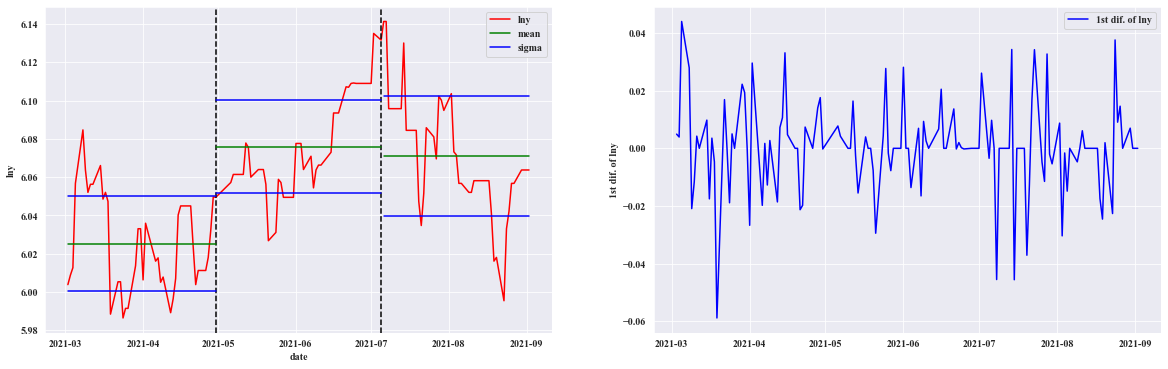

In [45]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121)
ax1.plot(pd.to_datetime(test['date'],format='%Y%m%d'),np.log(test['SC2212.INE']),label="lny",color="r")
plt.legend()
plt.axvline(pd.to_datetime(test['date'],format='%Y%m%d')[42],color = 'black',linestyle='--')
plt.axvline(pd.to_datetime(test['date'],format='%Y%m%d')[84],color = 'black',linestyle='--')
mean_1 = np.mean(np.log(test['SC2212.INE'])[0:42])
std_1 = np.std(np.log(test['SC2212.INE'])[0:42])
# plt.axhline(mean_1,color = 'black',linestyle='--')
plt.plot(pd.to_datetime(test['date'],format='%Y%m%d')[0:43],mean_1*np.ones(43),color = 'green',label = 'mean')
plt.plot(pd.to_datetime(test['date'],format='%Y%m%d')[0:43],mean_1*np.ones(43)+std_1,color = 'blue',label = 'sigma')
plt.plot(pd.to_datetime(test['date'],format='%Y%m%d')[0:43],mean_1*np.ones(43)-std_1,color = 'blue')

mean_2 = np.mean(np.log(test['SC2212.INE'])[43:84])
std_2 = np.std(np.log(test['SC2212.INE'])[43:84])
plt.plot(pd.to_datetime(test['date'],format='%Y%m%d')[42:85],mean_2*np.ones(43),color = 'green')
plt.plot(pd.to_datetime(test['date'],format='%Y%m%d')[42:85],mean_2*np.ones(43)+std_2,color = 'blue')
plt.plot(pd.to_datetime(test['date'],format='%Y%m%d')[42:85],mean_2*np.ones(43)-std_2,color = 'blue')

mean_3 = np.mean(np.log(test['SC2212.INE'])[84:])
std_3 = np.std(np.log(test['SC2212.INE'])[84:])
length =len(pd.to_datetime(test['date'],format='%Y%m%d')[85:])
plt.plot(pd.to_datetime(test['date'],format='%Y%m%d')[85:],mean_3*np.ones(length),color = 'green')
plt.plot(pd.to_datetime(test['date'],format='%Y%m%d')[85:],mean_3*np.ones(length)+std_3,color = 'blue')
plt.plot(pd.to_datetime(test['date'],format='%Y%m%d')[85:],mean_3*np.ones(length)-std_3,color = 'blue')


plt.legend(loc = 'best')
plt.xlabel("date")
plt.ylabel("lny")
ax2 = fig.add_subplot(122)
ax2.plot(pd.to_datetime(test['date'],format='%Y%m%d'),np.log(test['SC2212.INE']).diff(),label="1st dif. of lny",color="b")
plt.legend()
plt.ylabel("1st dif. of lny")

训练集中，两者的相关系数： 0.969225915918722
对lny平稳性检验
P-value:0.19
Result: the series is not stationary
对lnx平稳性检验
P-value:0.22
Result: the series is not stationary
对lny一阶差分平稳性检验
P-value:0.00
Result: the series is stationary
对lnx一阶差分平稳性检验
P-value:0.00
Result: the series is stationary
检验协整关系
P-value:0.00
Result: y 与 x 存在协整关系
最终训练出的参数为 start:0.50 stop: 1.25 take: 0.00
<class 'type'> matric:0.00


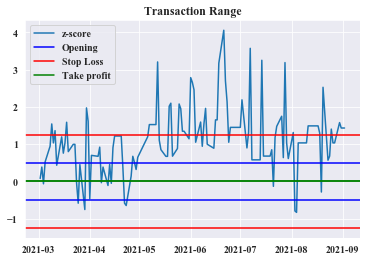

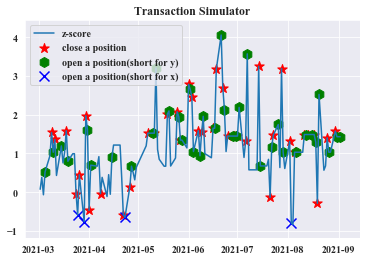

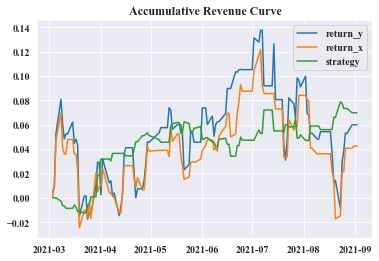

年化收益率：
return 1: 0.12  return 2: 0.08  strategy: 0.14
夏普率：
sharpe 1: 0.02  sharpe 2: 0.02  sharpe_strategy: 0.10
最大回撤率
withdrawn 1: 0.15  withdrawn 2: 0.14  withdrawn strategy: 0.03


In [36]:
model = Co_arbitrage(train_data=train,test_data=test)
model.train(type)
model.test()

训练集中，两者的相关系数： 0.969225915918722
对lny平稳性检验
P-value:0.19
Result: the series is not stationary
对lnx平稳性检验
P-value:0.22
Result: the series is not stationary
对lny一阶差分平稳性检验
P-value:0.00
Result: the series is stationary
对lnx一阶差分平稳性检验
P-value:0.00
Result: the series is stationary
检验协整关系
P-value:0.00
Result: y 与 x 存在协整关系
最终训练出的参数为 start:0.60 stop: 1.97 take: 0.50
sharp matric:24126.10


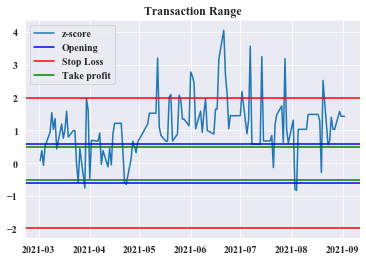

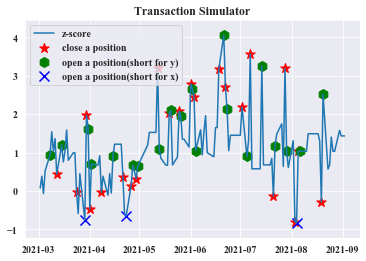

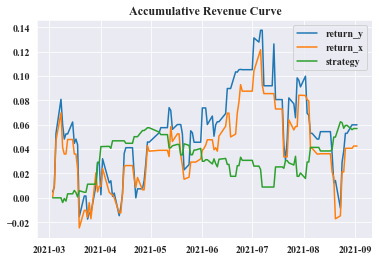

年化收益率：
return 1: 0.12  return 2: 0.08  strategy: 0.11
夏普率：
sharpe 1: 0.02  sharpe 2: 0.02  sharpe_strategy: 0.08
最大回撤率
withdrawn 1: 0.15  withdrawn 2: 0.14  withdrawn strategy: 0.05


In [23]:
model = Co_arbitrage(train_data=train,test_data=test)
model.train(type='sharp')
model.test()

训练集中，两者的相关系数： 0.969225915918722
对lny平稳性检验
P-value:0.19
Result: the series is not stationary
对lnx平稳性检验
P-value:0.22
Result: the series is not stationary
对lny一阶差分平稳性检验
P-value:0.00
Result: the series is stationary
对lnx一阶差分平稳性检验
P-value:0.00
Result: the series is stationary
检验协整关系
P-value:0.00
Result: y 与 x 存在协整关系
最终训练出的参数为 start:1.15 stop: 1.25 take: 0.20
withdraw matric:0.01


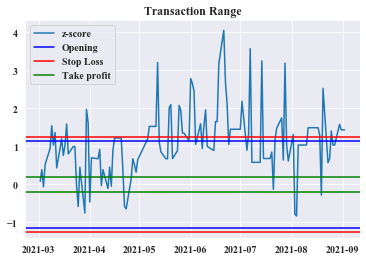

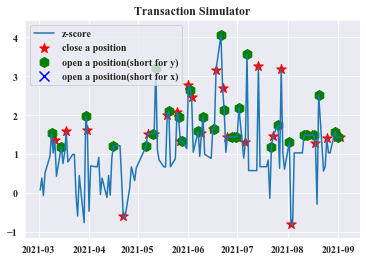

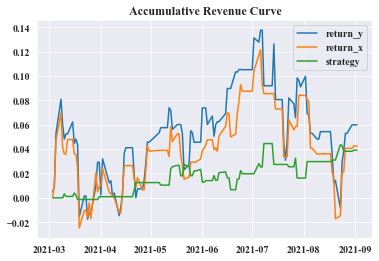

年化收益率：
return 1: 0.12  return 2: 0.08  strategy: 0.08
夏普率：
sharpe 1: 0.02  sharpe 2: 0.02  sharpe_strategy: 0.05
最大回撤率
withdrawn 1: 0.15  withdrawn 2: 0.14  withdrawn strategy: 0.03


In [24]:
model = Co_arbitrage(train_data=train,test_data=test)
model.train(type='withdraw')
model.test()